# RAG Agêntico

[Agentes de Recuperação](https://python.langchain.com/v0.2/docs/tutorials/qa_chat_history/#agents) são úteis quando queremos tomar decisões sobre quando recuperar informações de um índice.

Para implementar um agente de recuperação, simplesmente precisamos dar a um LLM acesso a uma ferramenta de recuperação.

Podemos incorporar isso ao [LangGraph](https://langchain-ai.github.io/langgraph/).

## Configuração

Primeiro, vamos baixar os pacotes necessários e configurar nossas chaves de API:

In [106]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [107]:
# Importando bibliotecas necessárias
import getpass  # Para entrada segura de senhas
import os       # Para manipulação de variáveis de ambiente

def configurar_chave_api(nome_chave: str, chave_alternativa: str = None) -> str:
    """
    Função que verifica e configura uma chave de API como variável de ambiente.
    Se a chave principal não for fornecida, tenta usar uma chave alternativa.
    
    Args:
        nome_chave (str): Nome da variável de ambiente principal
        chave_alternativa (str, opcional): Nome da variável de ambiente alternativa
        
    Returns:
        str: Nome da chave que foi configurada com sucesso
    """
    # Tenta configurar a chave principal
    if nome_chave not in os.environ:
        try:
            chave = getpass.getpass(f"Por favor, digite sua {nome_chave}: ")
            if chave.strip():  # Verifica se a chave não está vazia
                os.environ[nome_chave] = chave
                return nome_chave
            raise ValueError("Chave vazia fornecida")
        except (KeyboardInterrupt, ValueError) as e:
            print(f"\nChave {nome_chave} não configurada: {str(e)}")
            
            # Se houver uma chave alternativa, tenta configurá-la
            if chave_alternativa:
                print(f"Tentando configurar {chave_alternativa} como alternativa...")
                try:
                    chave = getpass.getpass(f"Por favor, digite sua {chave_alternativa}: ")
                    if chave.strip():
                        os.environ[chave_alternativa] = chave
                        return chave_alternativa
                except (KeyboardInterrupt, ValueError):
                    print(f"\nNão foi possível configurar {chave_alternativa}")
                    raise Exception("Nenhuma chave de API válida foi configurada")
    
    return nome_chave

# Tenta configurar primeiro a OpenAI, se falhar, tenta o Claude
try:
    chave_configurada = configurar_chave_api("OPENAI_API_KEY", "ANTHROPIC_API_KEY")
    print(f"Usando API: {chave_configurada}")
except Exception as e:
    print(f"Erro: {e}")
    print("O programa não pode continuar sem uma chave de API válida")
    raise

# Configura o User-Agent para identificação da aplicação
if "USER_AGENT" not in os.environ:
    os.environ["USER_AGENT"] = "scoras-academy-app"

Usando API: OPENAI_API_KEY


<div class="admonition tip">
    <p class="admonition-title">Configure o <a href="https://smith.langchain.com">LangSmith</a> para desenvolvimento com LangGraph</p>
    <p style="padding-top: 5px;">
        Cadastre-se no LangSmith para identificar rapidamente problemas e melhorar o desempenho dos seus projetos LangGraph. O LangSmith permite que você use dados de rastreamento para depurar, testar e monitorar seus aplicativos LLM construídos com LangGraph — saiba mais sobre como começar <a href="https://docs.smith.langchain.com">aqui</a>. 
    </p>
</div> 

## Retriever ou Recuperador

Primeiro, vamos indexar 2 URLs.

In [108]:
# Importando as bibliotecas necessárias
from langchain_community.document_loaders import WebBaseLoader  # Carregador de páginas web
from langchain_community.vectorstores import Chroma            # Banco de dados vetorial
from langchain_openai import OpenAIEmbeddings                 # Embeddings da OpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Divisor de texto

# URLs dos sites que serão processados
urls = [
    "https://www.bnsir.com.br/usado/comprar/sao-paulo/jardim-paulistano/7mm/400mts/4d/casa-com-localizacao-privilegiada-proxima-ao-shopping-iguatemi/36039",
]

# Carrega os documentos de cada URL
docs = [WebBaseLoader(url).load() for url in urls]
# Aplana a lista de documentos (converte lista de listas em uma única lista)
docs_list = [item for sublist in docs for item in sublist]

# Configura o divisor de texto usando o codificador tiktoken
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,      # Tamanho de cada pedaço de texto
    chunk_overlap=50     # Quantidade de sobreposição entre os pedaços
)
# Divide os documentos em pedaços menores
doc_splits = text_splitter.split_documents(docs_list)

# Adiciona ao banco de dados vetorial
vectorstore = Chroma.from_documents(
    documents=doc_splits,           # Documentos divididos
    collection_name="rag-chroma",   # Nome da coleção no Chroma
    embedding=OpenAIEmbeddings(),   # Modelo de embeddings da OpenAI
)
# Cria um recuperador a partir do banco de dados vetorial
retriever = vectorstore.as_retriever()

Then we create a retriever tool.

In [109]:
# Importando a ferramenta de criação de recuperador
from langchain.tools.retriever import create_retriever_tool

# Criando uma ferramenta de recuperação
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",  # Nome da ferramenta
    "Pesquise e retorne informações de cada imóvel, como endereço, preço, tipo de imóvel, aréa, etc, respondendo em português do Brasil",  # Descrição da ferramenta
)

# Lista de ferramentas disponíveis
tools = [retriever_tool]

## Agent State
 
We will define a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [110]:
# Importando tipos necessários para anotações
from typing import Annotated, Sequence, TypedDict

# Importando classe base para mensagens
from langchain_core.messages import BaseMessage

# Importando função para adicionar mensagens ao grafo
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """
    Define o estado do agente usando TypedDict.
    """
    # A função add_messages define como uma atualização deve ser processada
    # O padrão é substituir, mas add_messages indica que deve anexar
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

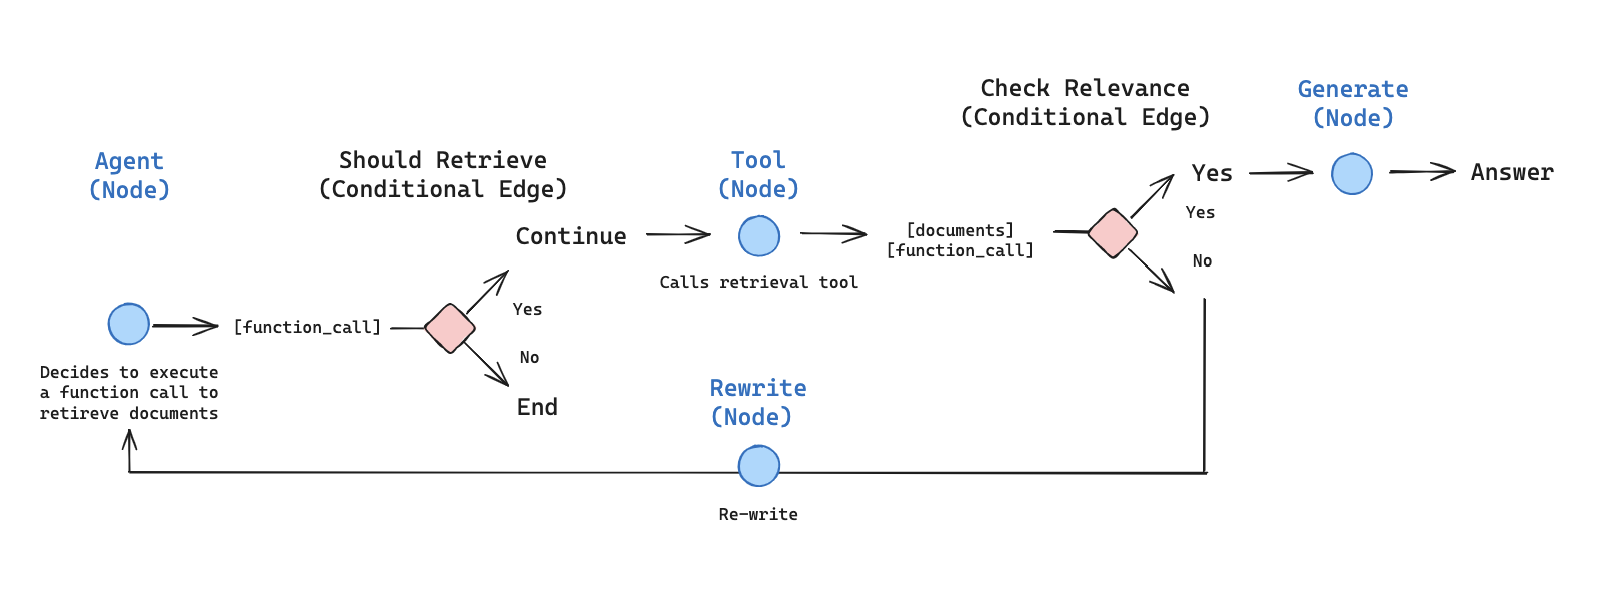

In [111]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition

### Arestas


def avaliar_documentos(state) -> Literal["gerar", "reescrever"]:
    """
    Determina se os documentos recuperados são relevantes para a pergunta.

    Args:
        state (messages): O estado atual

    Returns:
        str: Uma decisão sobre se os documentos são relevantes ou não
    """

    print("---VERIFICANDO RELEVÂNCIA---")

    # Modelo de dados
    class nota(BaseModel):
        """Pontuação binária para verificação de relevância."""

        pontuacao_binaria: str = Field(description="Pontuação de relevância 'sim' ou 'não'")

    # LLM
    modelo = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM com ferramenta e validação
    llm_com_ferramenta = modelo.with_structured_output(nota)

    # Prompt
    prompt = PromptTemplate(
        template="""Você é um avaliador analisando a relevância de um documento recuperado para uma pergunta do usuário. \n 
        Aqui está o documento recuperado: \n\n {context} \n\n
        Aqui está a pergunta do usuário: {question} \n
        Se o documento contiver palavra(s)-chave ou significado semântico relacionado à pergunta do usuário, classifique-o como relevante. \n
        Dê uma pontuação binária 'sim' ou 'não' para indicar se o documento é relevante para a pergunta.""",
        input_variables=["context", "question"],
    )

    # Cadeia
    cadeia = prompt | llm_com_ferramenta

    mensagens = state["messages"]
    ultima_mensagem = mensagens[-1]

    pergunta = mensagens[0].content
    docs = ultima_mensagem.content

    resultado_avaliado = cadeia.invoke({"question": pergunta, "context": docs})

    pontuacao = resultado_avaliado.pontuacao_binaria

    if pontuacao == "sim":
        print("---DECISÃO: DOCUMENTOS RELEVANTES---")
        return "gerar"

    else:
        print("---DECISÃO: DOCUMENTOS NÃO RELEVANTES---")
        print(pontuacao)
        return "reescrever"


### Nós


def agente(state):
    """
    Invoca o modelo do agente para gerar uma resposta baseada no estado atual.
    Dada a pergunta, decidirá se usa a ferramenta de recuperação ou simplesmente termina.
    Obrigatório lembrar que todas as respostas devem ser em português.

    Args:
        state (messages): O estado atual

    Returns:
        dict: O estado atualizado com a resposta do agente anexada às mensagens
    """
    print("---CHAMANDO AGENTE---")
    mensagens = state["messages"]
    modelo = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    modelo = modelo.bind_tools(tools)
    resposta = modelo.invoke(mensagens)
    # Retornamos uma lista, porque isso será adicionado à lista existente
    return {"messages": [resposta]}


def reescrever(state):
    """
    Transforma a consulta para produzir uma pergunta melhor.

    Args:
        state (messages): O estado atual

    Returns:
        dict: O estado atualizado com a pergunta reformulada
    """

    print("---TRANSFORMANDO CONSULTA---")
    mensagens = state["messages"]
    pergunta = mensagens[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Analise a entrada e tente compreender a intenção semântica/significado subjacente. \n 
    Aqui está a pergunta inicial:
    \n ------- \n
    {pergunta} 
    \n ------- \n
    Formule uma pergunta aprimorada: """,
        )
    ]

    # Avaliador
    modelo = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    resposta = modelo.invoke(msg)
    return {"messages": [resposta]}


def gerar(state):
    """
    Gera resposta

    Args:
        state (messages): O estado atual

    Returns:
         dict: O estado atualizado com a pergunta reformulada
    """
    print("---GERANDO---")
    mensagens = state["messages"]
    pergunta = mensagens[0].content
    ultima_mensagem = mensagens[-1]

    docs = ultima_mensagem.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Pós-processamento
    def formatar_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Cadeia
    cadeia_rag = prompt | llm | StrOutputParser()

    # Executar
    resposta = cadeia_rag.invoke({"context": docs, "question": pergunta})
    return {"messages": [resposta]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Mostra como é o prompt

********************Prompt[rlm/rag-prompt]********************


/home/anderson/miniconda3/envs/scoras_academy/lib/python3.12/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [112]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define um novo grafo
workflow = StateGraph(AgentState)

# Define os nós entre os quais vamos alternar
workflow.add_node("agente", agent)  # nó do agente
recuperador = ToolNode([retriever_tool])
workflow.add_node("recuperar", recuperador)  # nó de recuperação
workflow.add_node("reescrever", rewrite)  # nó para reescrever a pergunta
workflow.add_node(
    "gerar", generate
)  # nó para gerar uma resposta após confirmar que os documentos são relevantes

# Chama o nó do agente para decidir se recupera ou não
workflow.add_edge(START, "agente")

# Decide se deve recuperar
workflow.add_conditional_edges(
    "agente",
    # Avalia a decisão do agente
    tools_condition,
    {
        # Traduz as saídas da condição para nós em nosso grafo
        "tools": "recuperar",
        END: END,
    },
)

# Arestas tomadas após a chamada do nó de 'ação'
workflow.add_conditional_edges(
    "recuperar",
    # Avalia a decisão do agente
    avaliar_documentos,
)
workflow.add_edge("gerar", END)
workflow.add_edge("reescrever", "agente")

# Compila o grafo
graph = workflow.compile()

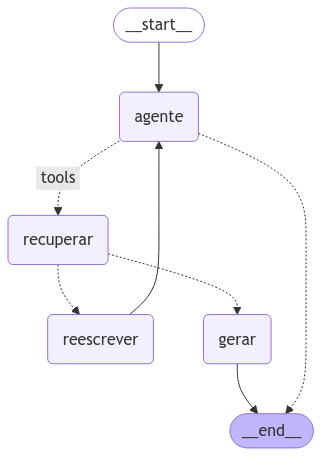

In [113]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # Isso requer algumas dependências extras e é opcional
    pass

In [114]:
import pprint

inputs = {
    "messages": [
        ("user", "Traga informações sobre imóveis. São importantes detalhes como metros quadrados, preço, tipo de imóvel, aréa, Dorms,preços em R$, e etc. Responda em português."),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agente':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_9RpmVzflqa7cYD22UQEtJ4CI', 'function': {'arguments': '{"query":"imóveis Jardim Paulistano"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb'}, id='run-d2ec563c-07be-4e95-a348-900858d9bbbd-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'imóveis Jardim Paulistano'}, 'id': 'call_9RpmVzflqa7cYD22UQEtJ4CI', 'type': 'tool_call'}])]}
'\n---\n'
---VERIFICANDO RELEVÂNCIA---
---DECISÃO: DOCUMENTOS NÃO RELEVANTES---
não
"Output from node 'recuperar':"
'---'
{ 'messages': [ ToolMessage(content='Comprar\n         \n          |\n         \n          Alugar\n        \n        Jardim Paulistano\n\nComprar\n         \n          |\n         \n          Alugar\n        \n        Jardim Paulistano\n\nCompra